In [2]:
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt

import requests
import urllib
import json
from urllib.parse import urlencode 
import re

In [3]:
sns.set(rc={'figure.figsize':(15,10)})

### Загружаем датасет с помощью Яндекс API

In [142]:
def yandex_to_pandas(links,sep=';'):
    for name, link in link_list.items():

        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = ''.join([link])
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        try:
            download_url = response.json()['href'] 
            download_response = requests.get(download_url) 
            globals()[f'{name}'] = pd.read_csv(download_url, sep=sep) 
            if globals()[f'{name}'].shape[1] == 1:
                globals()[f'{name}'] = pd.read_csv(download_url, sep=',')
                print ('dataframe name =',name,'| link =',public_key)
            else:
                print ('dataframe name =',name,'| link =',public_key)
        except:
            print("Link is not working")

In [143]:
link_list = {'groups':'https://disk.yandex.ru/d/UhyYx41rTt3clQ','group_add':'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ','active_studs':'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ','checks':'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'}

In [144]:
yandex_to_pandas(link_list)

dataframe name = groups | link = https://disk.yandex.ru/d/UhyYx41rTt3clQ
dataframe name = group_add | link = https://disk.yandex.ru/d/5Kxrz02m3IBUwQ
dataframe name = active_studs | link = https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ
dataframe name = checks | link = https://disk.yandex.ru/d/pH1q-VqcxXjsVA


In [145]:
# active_studs = pd.read_csv('Проект_2_active_studs.csv')
# checks = pd.read_csv('Проект_2_checks.csv', sep = ';')
# group_add = pd.read_csv('Проект_2_group_add.csv')
# groups = pd.read_csv('Проект_2_groups.csv', sep = ';')

# 1. A/B–тестирование

## Предварительный анализ

### 1. Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [146]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [147]:
#Общее описание данных
active_studs.describe()

,student_id
count,8.341000e+03
mean,2.448547e+06
std,1.564978e+06
min,1.627000e+03
25%,1.118405e+06
50%,2.094192e+06
75%,3.638877e+06
max,5.951797e+06


In [148]:
active_studs.shape

(8341, 1)

In [149]:
#Функция для проверки повторения данных
def dupl_row(df):
    if  df.nunique()[0]-df.shape[0] == 0:
        print ('Повторений НЕТ')
    else: 
        print (f'Повторений {df.nunique()-df.shape[0]}')
    

In [150]:
dupl_row(active_studs)

Повторений НЕТ


In [151]:
active_studs.dtypes

student_id    int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcb43b3c50>]],
      dtype=object)

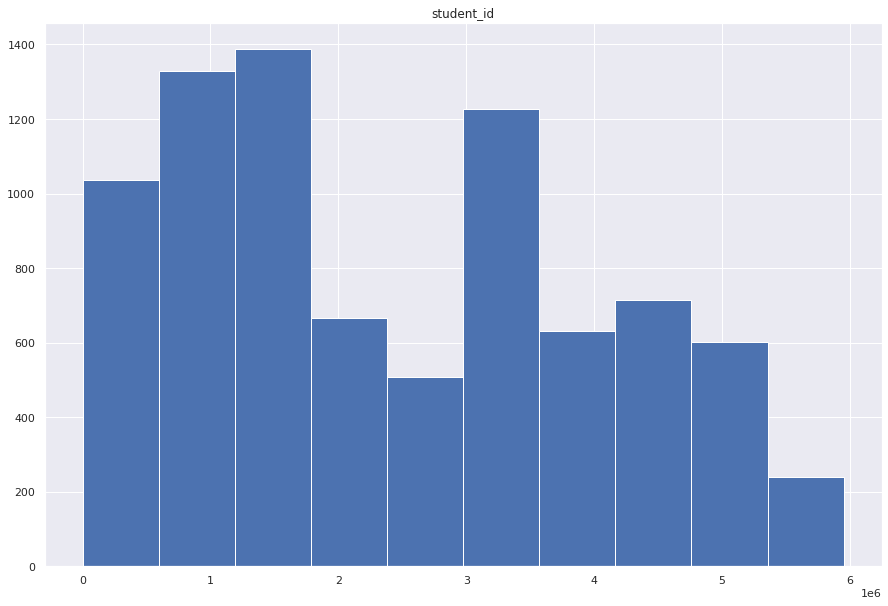

In [152]:
active_studs.hist() #смысла большого нет конечно, но интересно

### 2. Файл с информацией об оплатах пользователей в дни проведения эксперимента

In [153]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [154]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [155]:
checks.shape

(541, 2)

In [156]:
dupl_row(checks)

Повторений НЕТ


In [157]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

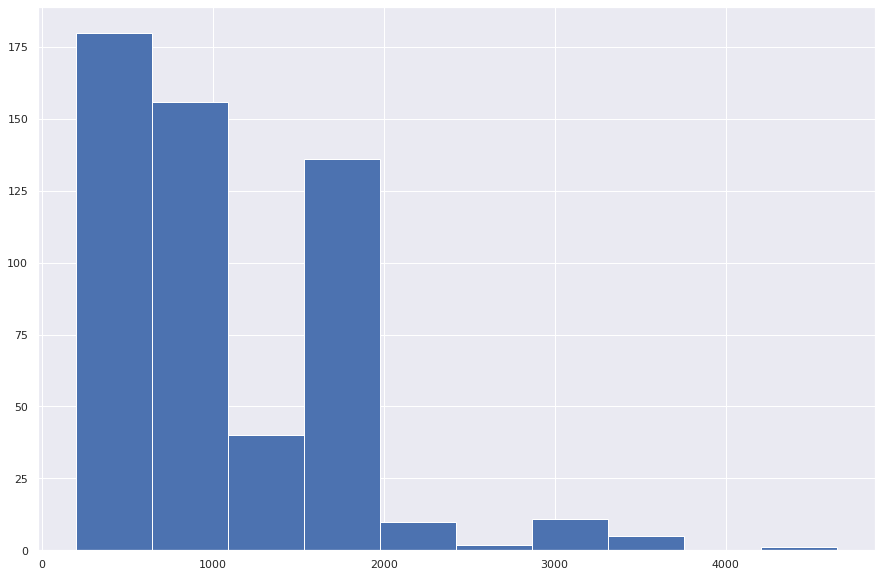

In [158]:
checks.rev.hist()

### 3. Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [159]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [160]:
groups.shape

(74484, 2)

In [161]:
dupl_row(groups)

Повторений НЕТ


In [162]:
groups.dtypes

id      int64
grp    object
dtype: object

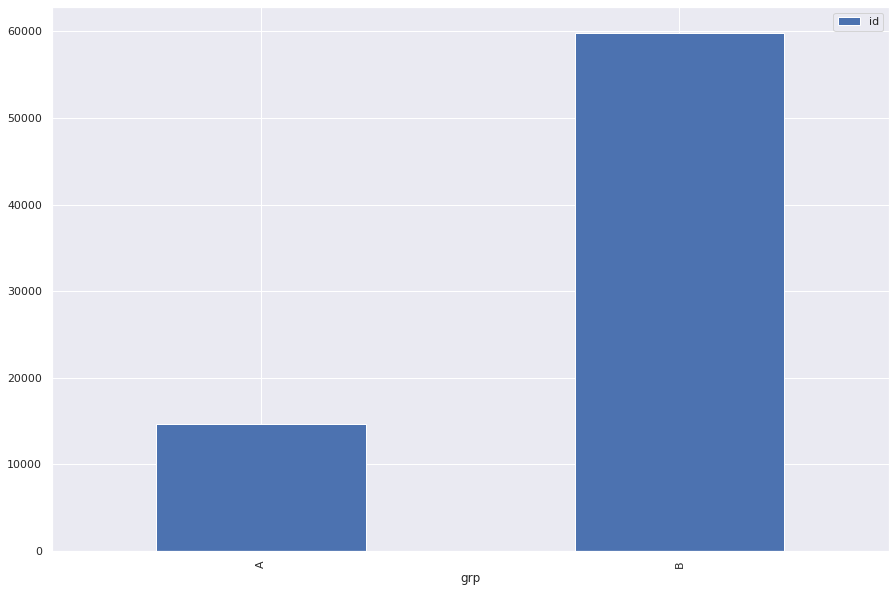

In [163]:
groups.groupby('grp').agg({'id':'nunique'}).plot.bar() 
#Экспериментальная группа "В" в примерно в 4 раза превосходит Контрольную группу "А"

In [164]:
groups.groupby('grp').agg({'id':'nunique'})

,id
grp,
A,14671
B,59813


### 4. Дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных

In [165]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [166]:
group_add.shape

(92, 2)

In [167]:
dupl_row(group_add)

Повторений НЕТ


In [168]:
group_add.dtypes

id      int64
grp    object
dtype: object

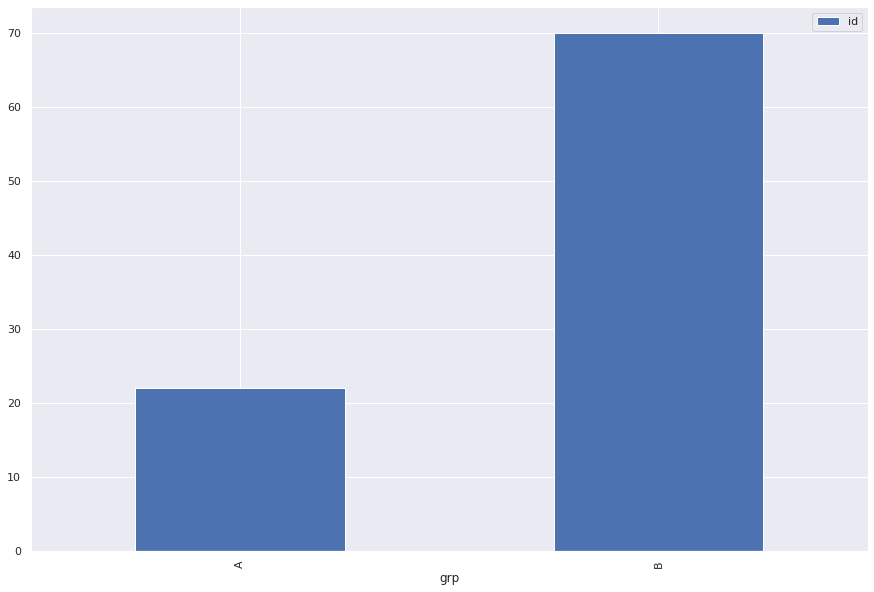

In [169]:
group_add.groupby('grp').agg({'id':'nunique'}).plot.bar() 

In [170]:
group_add.groupby('grp').agg({'id':'nunique'})

,id
grp,
A,22
B,70


#### Проверю есть ли пропуски в датафреймах

In [171]:
def isna (list_df):
    nnn = []
    for df in list(list_df):
        nas = list_df[df].shape[0]-list_df[df].dropna().shape[0]
        df_name = df
        print(f'{nas} пустых ячеек в датафрейме {df_name}')
    nnn.append(nas)
    if sum(nnn) == 0:
        print ('\nПУСТЫХ ЯЧЕЕК НЕТ')
    else:
        print('\nПУСТЫЕ ЯЧЕЙКИ ЕСТЬ')

In [172]:
dfs = {'active_studs':active_studs,'checks':checks,'group_add':group_add,'groups':groups}

In [173]:
isna(dfs)

0 пустых ячеек в датафрейме active_studs
0 пустых ячеек в датафрейме checks
0 пустых ячеек в датафрейме group_add
0 пустых ячеек в датафрейме groups

ПУСТЫХ ЯЧЕЕК НЕТ


#### Приведем все колонки id к одному названию

In [174]:
def column_name (list_df):
    for df in list (list_df):
        try:
            globals()[f'{df}'] = list_df[df].rename(columns = {'student_id':'id'})
        except:
            pass
    print ('Все переименовано в id')

In [175]:
column_name(dfs)

Все переименовано в id


#### Сверим совпадают ли пользователи, которые покупали и заходили на сайт

In [176]:
checks.merge(active_studs.assign(x = 1), on='id', how='left').query('x!=1')[['id','rev']]

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Интересно, что объем данных в файле groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе во много раз превышает объем файла active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

Если система сплитования назначает группу пользователя в момент захода на платформу в период эксперимента, то исходя их описания данных, объем данных в таблицах должен совпадать. Но так как данные сильно отличаются, видимо сплитование было проведено заранее, в том числе по пользователям, которые не пользовались платформой в период эксперимента. 

Кроме этого были выявлена аномалия в данных - датасете присутствуют пользователи, которые совершили покупку, но не заходили на сайт, что также ставит под сомнение качество исходных данных. Так как нет возможности проверить с чем это связано, считаю ошибкой и не учитываю их.         

<b>Таким образом, в данном анализе будем учитывать только тех пользователей, которые пользовались платформой в период эксперимента.</b>


## Метрики для оценки изменения после введения новой системы оплаты:
    1. Коверсия в покупку
    2. Средняя выручка на пользователя (ARPU)
    

### Подготовка данных

Объединим две таблицы с данными по группам

In [177]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [178]:
group_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [179]:
final_group = pd.concat([groups,group_add])

Проверим есть ли повторения в столбце id

In [180]:
final_group.shape

(74576, 2)

In [181]:
final_group.id.nunique() #Повторений в id нет

74576

Укажем группу пользователям, которые заходили в период тесторивания

In [182]:
studs_grp = active_studs.merge(final_group, how='left', on = 'id') 

In [183]:
#Проверим корректно ли выполнился мердж
active_studs.shape[0]-studs_grp.shape[0]

0

Посмотрим на распределение по группам 

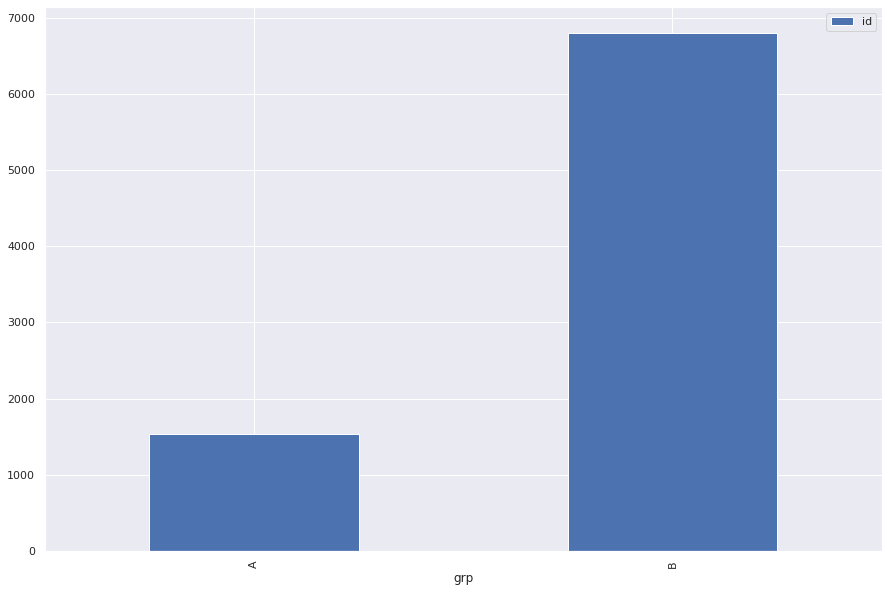

In [184]:
studs_grp.groupby('grp').agg({'id':'nunique'}).plot.bar()

In [185]:
studs_grp

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


Добавим столбец с данным по оплате

In [186]:
studs_grp_rev = studs_grp.merge(checks, on = 'id', how ='left')

Добавим вспомогательный столбец с фактом покупки

In [187]:
studs_grp_rev['bought'] = studs_grp_rev.rev.apply(lambda x: 'bought' if x > 0 else 'not_bought')

In [188]:
studs_grp_rev.groupby('bought').agg({'rev':'sum'})

,rev
bought,
bought,467794.0035
not_bought,0.0000


Если правильно посчиталось, в сумма группе 1  должна совпадать с суммой по всей таблице

In [189]:
studs_grp_rev.rev.sum() #Совпало

467794.00350000005

In [190]:
studs_grp_rev

,id,grp,rev,bought
0,581585,A,NaN,not_bought
1,5723133,A,NaN,not_bought
2,3276743,B,NaN,not_bought
3,4238589,A,NaN,not_bought
4,4475369,B,NaN,not_bought
...,...,...,...,...
8336,1794344,B,NaN,not_bought
8337,296883,B,NaN,not_bought
8338,3598448,B,NaN,not_bought
8339,3610547,B,290.0,bought


## Гипотезы об изменении метрик

### 1. Конверсия

Н0 - Конверсия не изменилась после введения новой механики оплаты               
Н1 - Конверсия изменилась после введения новой механики оплаты

In [191]:
conv_df = studs_grp_rev.groupby(['grp','bought'],as_index=False).agg({'id':'nunique'})\
            .pivot(columns='bought', index='grp', values='id').assign(activ_users = lambda x: x.bought+x.not_bought)[['bought','activ_users']]
conv_df

bought,bought,activ_users
grp,,
A,78,1538
B,314,6803


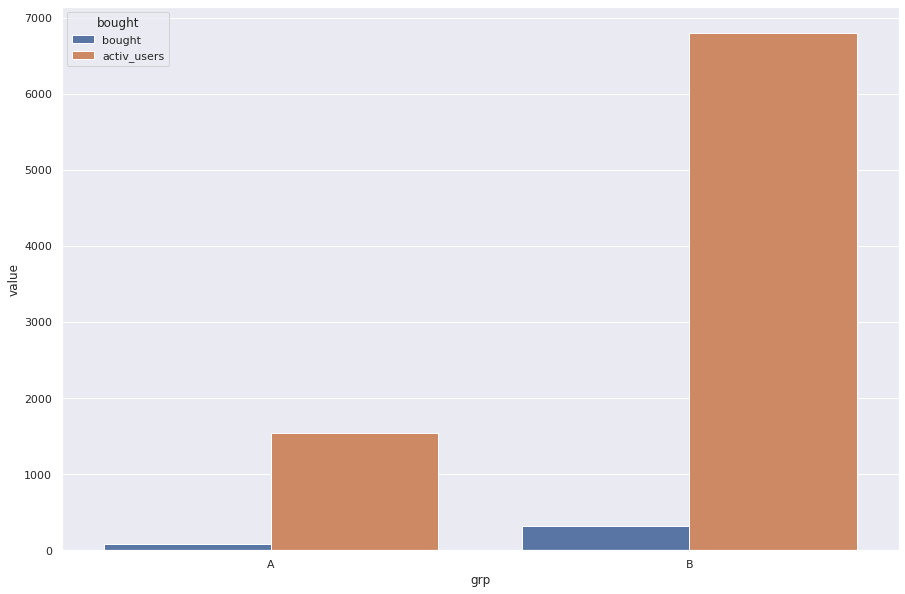

In [192]:
sns.barplot(data=conv_df.reset_index().melt(id_vars='grp'), x='grp', y='value', hue='bought')

Данные по Конверсии представляют собой Пропорцию, имеют больше 5 наблюдений, а также предпологаем что покупатели независимы друг от друга, следовательно для оценки используем Хи‑Квадрат

In [193]:
chi2, p, dof, ex = chi2_contingency(conv_df, correction=False)

In [194]:
p

0.4672642540463894

In [195]:
p > 0.05

True

p > 0.05 Следовательно принимаем нулевую гипотезу <b>Конверсия не изменилась</b> после введения новой механика оплаты

### 2. Выручка на пользователя (ARPU)

Н0 - Выручка на пользователя не изменилась после введения новой механики оплаты   
Н1 - Выручка на пользователя изменилась после введения новой механики оплаты

Для удобавста дальнейшей обработк разделим в два датафрейма по группам

In [196]:
avg_rev_a = studs_grp_rev[(studs_grp_rev.grp =='A')].dropna()
avg_rev_a

,id,grp,rev,bought
62,1184303,A,1530.0,bought
99,720651,A,1980.0,bought
306,4337103,A,580.0,bought
392,332387,A,2910.0,bought
439,1659434,A,690.0,bought
...,...,...,...,...
7950,445767,A,3660.0,bought
8025,1202202,A,2910.0,bought
8027,2306271,A,290.0,bought
8204,1390994,A,398.0,bought


In [197]:
avg_rev_b = studs_grp_rev[(studs_grp_rev.grp =='B')].dropna()
avg_rev_b

,id,grp,rev,bought
67,3354191,B,1900.0001,bought
77,3278734,B,1900.0000,bought
193,1232221,B,1900.0000,bought
195,3821501,B,1900.0000,bought
211,1036096,B,1900.0000,bought
...,...,...,...,...
8109,2692209,B,1900.0001,bought
8191,2081846,B,1900.0000,bought
8201,3890326,B,199.0000,bought
8277,3910596,B,597.0000,bought


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


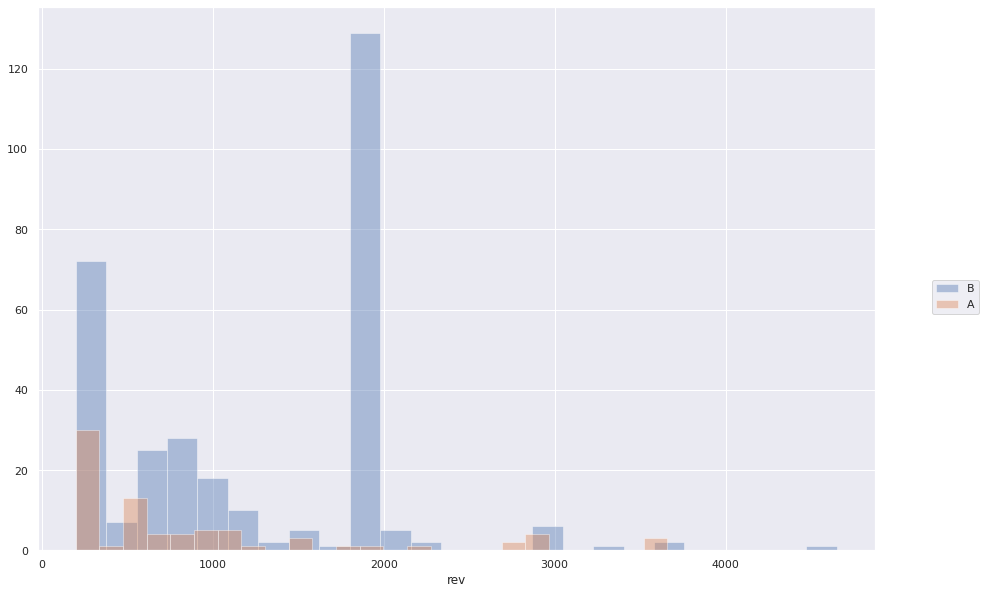

In [198]:
fig = plt.figure(figsize=(15,10))
sns.distplot(avg_rev_b.rev, bins=25, kde=False)
sns.distplot(avg_rev_a.rev, bins=25, kde=False)
fig.legend(labels=['B','A'],loc='right')
plt.show()

Имеется неизвестная аномалия в группе В

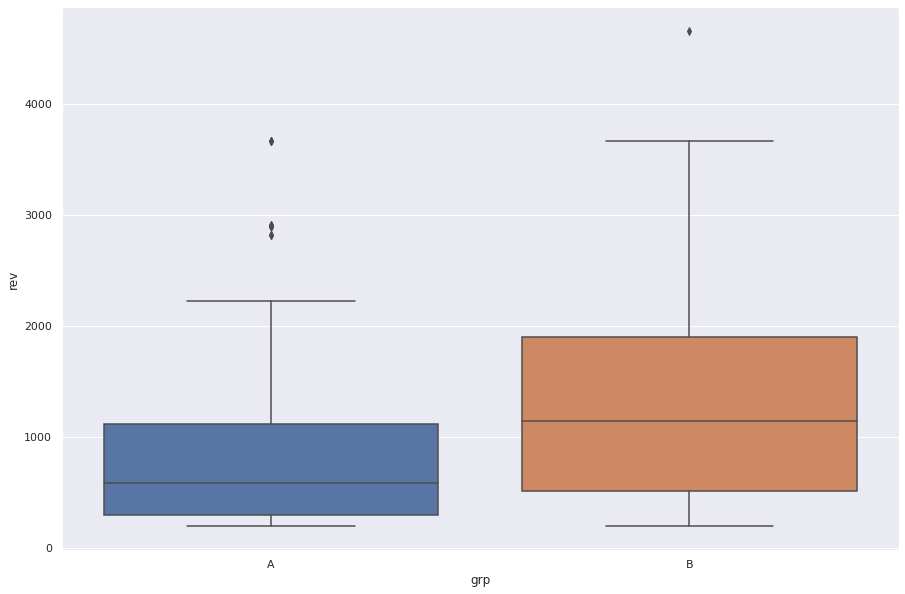

In [199]:
sns.boxplot(data=studs_grp_rev[studs_grp_rev.rev > 0].groupby(['grp','id'],as_index=False).agg({'rev':'sum'}), y='rev', x='grp')

Проверим распеределения на нормальность

In [200]:
sh_new = stats.shapiro(np.log(avg_rev_b.rev))[1]
sh_old = stats.shapiro(np.log(avg_rev_a.rev))[1]

print (f'pvalue dist_1 {sh_new}, pvalue dist_2 {sh_old}')

pvalue dist_1 2.9242029102554055e-17, pvalue dist_2 2.680935176613275e-05


Нормальность отвергается у обоих. Используем непараметрические тесты - Критерий Колмогорова-Смирнова, а также посмотрим на результат методом bootstrap.

###### Тест Колмогорова-Смирнова

In [326]:
stat,p = stats.ks_2samp(avg_rev_a.rev, avg_rev_b.rev)

print("statistic: ", stat)
print("p-value: ", p)

statistic:  0.323942511840601
p-value:  2.3982639157926755e-06


In [325]:
p<0.05

True

##### Bootstrap

In [226]:
# Назначаем количество сэмплов
n_bootstrap = 10000

# Лист для значений p и разности средних
list_of_p =[]
bootstrap_diff = []

# генерирует сэмплы и расчитываем средние
for i in range(n_bootstrap):
    test_sample = np.random.choice(avg_rev_b.rev, size=len(avg_rev_b.rev), replace=True)
    control_sample = np.random.choice(avg_rev_a.rev, size=len(avg_rev_a.rev), replace=True)
    bootstrap_diff.append(np.mean(test_sample) - np.mean(control_sample))
    bs_diff = np.array(bootstrap_diff)
# проводим т-тесты
    t, p = stats.ttest_1samp(bootstrap_diff, 0)
    list_of_p.append(p)

(0.0, 50.0)

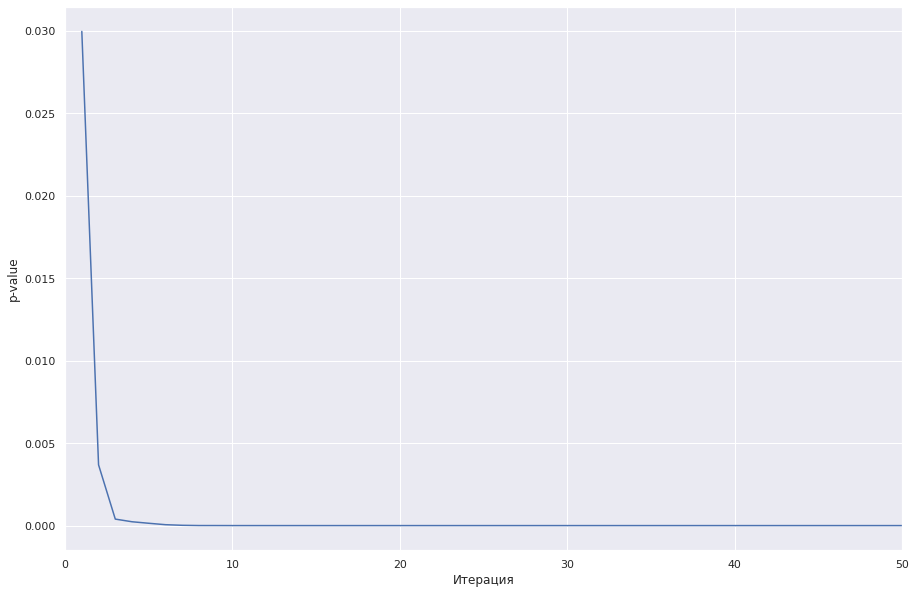

In [317]:
#Смотрим итерации p-value
sns.lineplot(y=list_of_p,x=range(10000)).set (xlabel='Итерация', ylabel='p-value')
plt.xlim(0, 50)

In [319]:
#Считаем фаинальные значения доверительного интервала, t статистики и p-value
ci = np.percentile(bootstrap_diff, [2.5, 97.5])

print("Bootstrap mean difference 95% CI: ({:.2f}, {:.2f})".format(ci[0], ci[1]))
print("t-statistic: ", t)
print("p-value: ", p)

Bootstrap mean difference 95% CI: (95.74, 537.06)
t-statistic:  288.51456090730835
p-value:  0.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


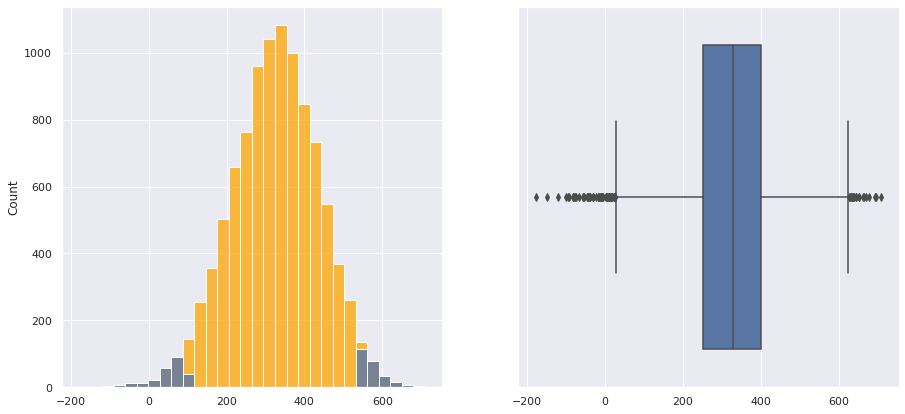

In [320]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15, 7)
sns.histplot([x for x in bs_diff if (x>ci[0])|(x<ci[1])], bins=30,color='orange',ax=ax[0])
sns.histplot([x for x in bs_diff if (x<ci[0])|(x>ci[1])], bins=30,ax=ax[0])
sns.boxplot(bs_diff,ax=ax[1])

Оба теста показали, что p < 0.05 Следовательно отвергаем нулевую гипотезу - <b>Выручка на пользователя изменилась</b> после введения новой механика оплаты

## Вывод

В ходе анализа были оценены такие метрики как:
1. Конверсия в покупку
2. Выручка на пользователя ARPU


Также обычно необходимо смотреть на Кол-во покупок на пользователя, Ретеншен. Но в данном наборе данных каждый пользователь сделал только одну покупку.

Исходя из полученных данных можно утверждать, что основная метрика <b>Конверсия в покупку</b> после введения новой механики оплаты стат значимо <b>не изменилась</b>. Изменение <b>Выручки на пользователя</b> без изменения конверсии больше похоже на ошибку на этапе сплитования групп. Возможно в нее попали разные кластеры пользователей или была раскатана новая РК на продукт, который стоит около 2000 Д.Е. Для четкой оценки хотелось бы посмотреть на систему сплитования и результаты А/А теста.

Таким образом, учитывая что сновная метрика Конверсия в покупку стат значимо не изменилась после введения новой механики оплаты, а данные по Выручке на пользователя требуют дополнительной верификации, <b>рекомендуется пока не вводить новую мехнику оплаты.</b>


# 2. SQL

Импорт необходиомой библиотеки и переменной данных подключения

In [566]:
import pandahouse as ph

In [567]:
connection_default = {'host': click,
                      'database': default,
                      'user': user, 
                      'password': paswrd
                     }

## 2.1 Кол-во усердных учеников
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов. (Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.)

In [151]:
q = '''
SELECT COUNT(st_id) as committed_students
FROM (
    SELECT st_id,
    SUM(correct) as correct_peas
        FROM default.peas
        WHERE timest >= (
            SELECT MAX(timest)
            FROM default.peas
            ) - INTERVAL 1 MONTH
        AND correct = 1
        GROUP BY st_id
        HAVING correct_peas >= 20
        )
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
count_of_committed_students = ph.read_clickhouse(query=q, connection=connection_default)
cs = count_of_committed_students['committed_students'][0]
print (f'Количество очень усердных студентов {cs}')

Количество очень усердных студентов 136


## 2.2 Оптимизация воронки
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

1. ARPU 
2. ARPAU 
3. CR в покупку 
4. СR активного пользователя в покупку 
5. CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
6. ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [152]:
q = '''
SELECT 
    test_grp,
    sum(money_of_students)/uniqExact(all_students) as ARPU,
    sum(money_of_students)/uniqExact(activ_students) as ARPAU,
    uniqExact(bay_sudents)/uniqExact(all_students) as CR,
    uniqExact(activ_bay_students)/uniqExact(activ_students) as CRa,
    uniqExact(activ_math_bay_st)/uniqExact(activ_math_st) as CRa_math

FROM
    (SELECT 
        all_st_sel.st_id as all_students,
        pay_st_sel.st_id as bay_sudents,
        pay_st_sel.money_all as money_of_students,
        activ_st_sel.activ_st as activ_students,
        activ_st_sel.activ_pay_st as activ_bay_students,
        math.activ_math_st as activ_math_st,
        math.activ_math_bay_st as activ_math_bay_st,
        grp_sel.test_grp as test_grp
        
        
    FROM
        (SELECT DISTINCT st_id FROM default.studs) as all_st_sel
    
    LEFT JOIN 
        (SELECT a.st_id as activ_st, pay_activ_st.st_id as activ_pay_st
        FROM
            (SELECT st_id
            FROM default.peas
            GROUP BY st_id
            HAVING sum(correct) > 10) as a
        
        LEFT JOIN 
            (SELECT st_id FROM default.final_project_check) as pay_activ_st
        ON
            a.st_id = pay_activ_st.st_id) as activ_st_sel
    ON
        all_st_sel.st_id = activ_st_sel.activ_st
    
    LEFT JOIN 
        (SELECT st_id, avg(money) as money_all FROM default.final_project_check GROUP BY st_id) as pay_st_sel
    ON
        all_st_sel.st_id = pay_st_sel.st_id
    
    LEFT JOIN 
        (SELECT a.activ_math_st as activ_math_st, b.st_id as activ_math_bay_st
        FROM
            (SELECT 
                st_id as activ_math_st
            FROM 
                default.peas
            WHERE 
                subject = 'Math'
            GROUP BY
                st_id
            HAVING
                sum(correct) > 1) as a
        LEFT JOIN 
            (SELECT st_id FROM default.final_project_check) as b
        ON
            a.activ_math_st = b.st_id) as math
    ON 
        all_st_sel.st_id = math.activ_math_st
        
    LEFT JOIN
        default.studs as grp_sel
    ON 
        all_st_sel.st_id = grp_sel.st_id)

GROUP BY test_grp
       
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
metrics_by_group = ph.read_clickhouse(query=q, connection=connection_default)
metrics_by_group

,test_grp,ARPU,ARPAU,CR,CRa,CRa_math
0,control,5049.180328,12031.25000,0.052459,0.117188,0.120000
1,pilot,15084.745763,45876.28866,0.111864,0.268041,0.162791


### Функция догрузки


In [473]:
def get_new_data (link, sep=','):
   
    ##### функция берет файл по ссылке 
    def yandex_to_pandas(link, sep=sep):
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = ''.join(link)
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        try:
            download_url = response.json()['href'] 
            download_response = requests.get(download_url) 
            df_group_add = pd.read_csv(download_url, sep=sep, names=['id','grp'] ,header=0)
        except pd.errors.ParserError  as text_exception:
            download_url = response.json()['href'] 
            download_response = requests.get(download_url) 
            df_group_add = pd.read_csv(download_url, sep=sep)
        except:
            print("Link is not working")
        return df_group_add
    
    ##### функция берет файл по локальному адресу
    def csv_to_pandas(link,sep=sep):
        try:
            df_group_add = pd.read_csv(link, sep=sep, names=['id','grp'],header=0)
        except pd.errors.ParserError  as text_exception:
            df_group_add = pd.read_csv(link, sep=sep)
        return df_group_add
    
    ##### функция делает общую таблицу
    def process_df (df_group_add):
        final_group = pd.concat([groups,df_group_add])
        studs_grp = active_studs.rename(columns={'student_id':'id'}).merge(final_group, how='left', on = 'id') 
        studs_grp_rev = studs_grp.merge(checks.rename(columns={'student_id':'id'}), on = 'id', how ='left')
        studs_grp_rev['bought'] = studs_grp_rev.rev.apply(lambda x: 'bought' if x > 0 else 'not_bought')
        return studs_grp_rev
    
    ##### функция высчитывает метрики
    def process_metrics(processed_df):
        metrics_of_data = processed_df.groupby('id',as_index=False)\
                            .agg(grp = ('grp',lambda x: x),
                                 revenue_sum = ('rev','sum'),
                                 revenue_avg = ('rev','mean'),
                                 bought = ('bought',(lambda x: x.apply(lambda x: 1 if x == 'bought' else 0).sum())))\
                            .assign(pay_user = lambda x: x.bought.apply(lambda x: 1 if x > 0 else 0))\
                        .groupby('grp').agg(revenue=('revenue_sum', lambda x: x.sum().round(2)),
                                        users=('id','count'),
                                        pay_users=('pay_user','sum'),
                                        orders=('bought','sum'))\
                        .assign(ARPU = lambda x: (x['revenue']/x['users']).round(2),
                                ARPPU = lambda x: (x['revenue']/x['pay_users']).round(2),
                                CR = lambda x: (x['orders']/x['users']).round(5),
                                AOV = lambda x: (x['revenue']/x['orders']).round(2)
                               )    
        return metrics_of_data
    
    
    
    
    
    # Проверяет какой вид ссылки был дан
    if 'http' in link and 'yandex' in link:
        df_group_add = yandex_to_pandas(link, sep=sep)
    else:
        df_group_add = csv_to_pandas(link,sep=sep)
    
    # Проверяет размер полученной таблтицы
    if df_group_add.shape[1] != 2:
        print('В таблице должно быть 2 колонки. Попробуй изменить знак разделителя')
    else:
        processed_df = process_df(df_group_add)
        metrics_of_data = process_metrics(processed_df)

    
    return metrics_of_data
    
    

In [563]:
df = get_new_data('Проект_2_group_add.csv',sep=',')

In [564]:
df

,revenue,users,pay_users,orders,ARPU,ARPPU,CR,AOV
grp,,,,,,,,
A,72820.0,1538,78,78,47.35,933.59,0.05072,933.59
B,394974.0,6803,314,314,58.06,1257.88,0.04616,1257.88


### Функция строит базовые графики по метрикам графики

In [562]:
def graf_metrics (dff):
    fig = plt.figure(figsize=(15,25))

    plt.subplot (4, 1, 1)
    ax =sns.barplot(data=dff.reset_index()[['grp','users','pay_users']].melt(id_vars='grp'), x='grp', y='value', hue='variable')\
                        .set (xlabel='Группа', ylabel='Кол-во пользователей')
    plt.title ("Пользователи", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 3)
    sns.barplot(data=dff.reset_index()[['grp','revenue']], x='grp', y='revenue')\
                        .set (xlabel='Группа', ylabel='Выручка')
    plt.title ("Выручка", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 4)
    sns.barplot(data=dff.reset_index()[['grp','orders']], x='grp', y='orders')\
                        .set (xlabel='Группа', ylabel='Кол-во покупок')
    plt.title ("Покупки", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 5)
    sns.barplot(data=dff.reset_index()[['grp','ARPU']], x='grp', y='ARPU')\
                        .set (xlabel='Группа', ylabel='ARPU')
    plt.title ("ARPU", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 6)
    sns.barplot(data=dff.reset_index()[['grp','ARPPU']], x='grp', y='ARPPU')\
                        .set (xlabel='Группа', ylabel='ARPPU')
    plt.title ("ARPPU", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 7)
    sns.barplot(data=dff.reset_index()[['grp','CR']], x='grp', y='CR')\
                        .set (xlabel='Группа', ylabel='CR')
    plt.title ("CR", fontweight="bold",fontsize=15)


    plt.subplot (4, 2, 8)
    sns.barplot(data=dff.reset_index()[['grp','AOV']], x='grp', y='AOV')\
                        .set (xlabel='Группа', ylabel='AOV')
    plt.title ("AOV", fontweight="bold",fontsize=15)

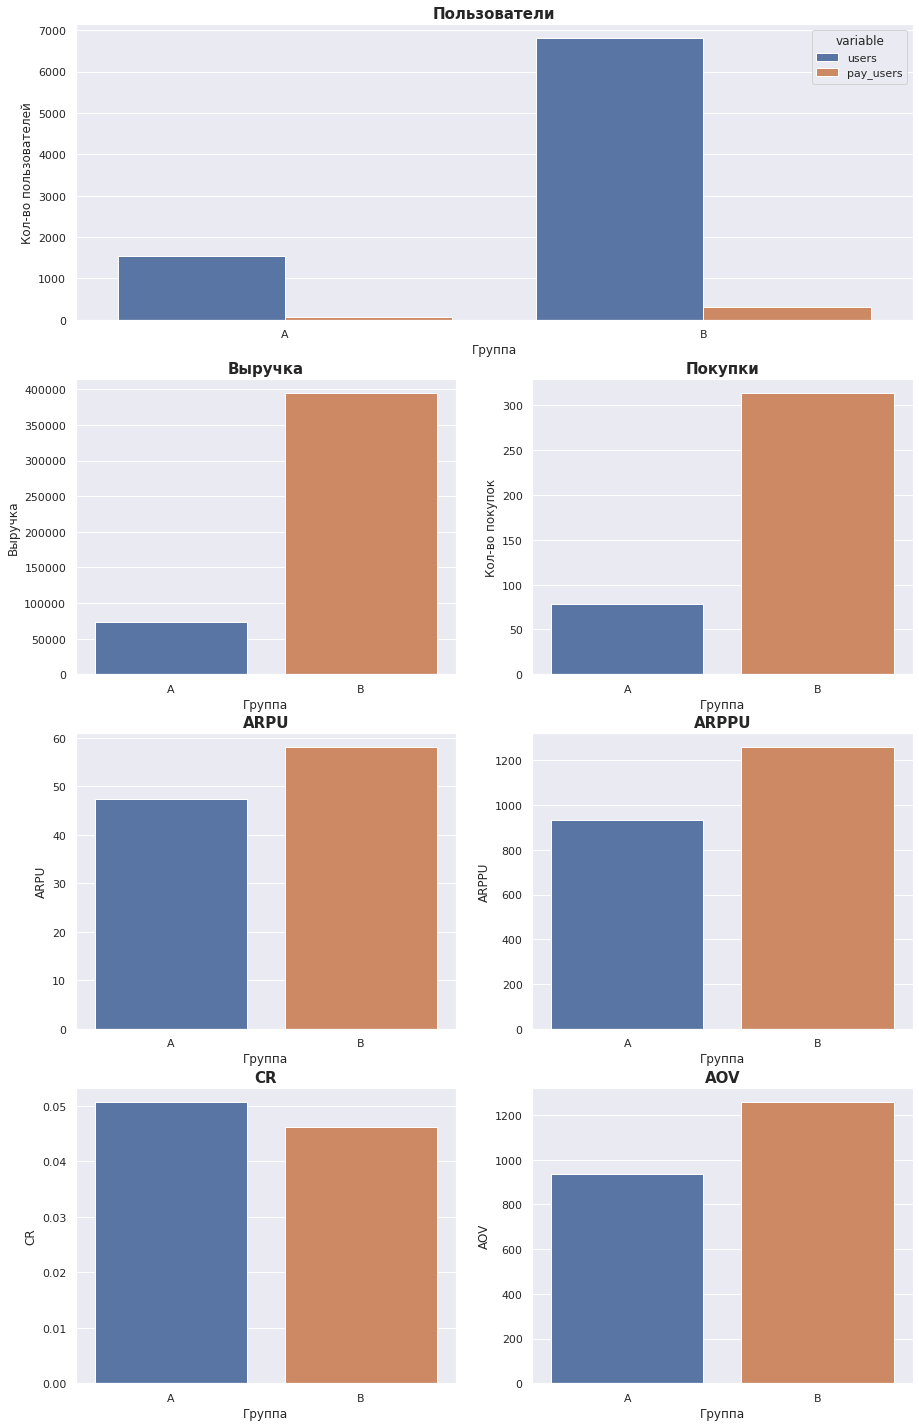

In [565]:
graf_metrics(df)